In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Alphabet and mapping from character to integer
alphabet = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', ' ']
char_to_int = {c: i for i, c in enumerate(alphabet)}
num_chars = len(alphabet)

def one_hot(indices, num_classes):
    # Converts indices to one-hot encoded tensor
    return F.one_hot(indices, num_classes=num_classes)

def encode_string(string, length):
    # Encodes a string into a one-hot encoding with padding added at the end
    encoded = torch.tensor([char_to_int[char] for char in string])
    padding = torch.full((length - len(encoded),), num_chars-1)  # Padding with index of ' '
    padded_encoded = torch.cat((encoded, padding))
    return one_hot(padded_encoded, num_classes=num_chars).float()

# Generating and encoding data
generated_queries = []
generated_answers = []
for x in range(100):
    for y in range(100):
        generated_queries.append('{:02d}+{:02d}'.format(x, y))
        generated_queries.append('{:02d}-{:02d}'.format(x, y))
        generated_answers.append('{:+03d}'.format(x+y))
        generated_answers.append('{:+03d}'.format(x-y))

X = torch.stack([encode_string(q, 5) for q in generated_queries])
Y = torch.stack([encode_string(a, 4) for a in generated_answers])


In [5]:
# Splitting the dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# Defining the neural network
class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)  # Added an extra layer
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)  # Added dropout

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Initializing the models, loss, and optimizers for baseline and reversed
model_baseline = FNN(input_size=5*13, hidden_size=128, output_size=4*13)
model_reversed = FNN(input_size=5*13, hidden_size=128, output_size=4*13)  # Same size for fair comparison

criterion = nn.CrossEntropyLoss()
optimizer_baseline = optim.Adam(model_baseline.parameters(), lr=0.001)
optimizer_reversed = optim.Adam(model_reversed.parameters(), lr=0.001)  # Unified learning rate

# Training loop
epochs = 100  # Increased number of epochs
val_acc, val_acc_rev = [], []

for epoch in range(epochs):
    # Training Baseline model
    model_baseline.train()
    optimizer_baseline.zero_grad()
    output_baseline = model_baseline(X_train)
    output_baseline = output_baseline.view(-1, 13)
    target_baseline = torch.argmax(Y_train.view(Y_train.size(0), 4, -1), dim=2).view(-1)
    loss_baseline = criterion(output_baseline, target_baseline)
    loss_baseline.backward()
    optimizer_baseline.step()

    # Training Reversed model
    model_reversed.train()
    optimizer_reversed.zero_grad()
    output_reversed = model_reversed(X_train)
    output_reversed = output_reversed.view(-1, 13)
    target_reversed = torch.argmax(Y_train.view(Y_train.size(0), 4, -1), dim=2).view(-1)
    loss_reversed = criterion(output_reversed, target_reversed)
    loss_reversed.backward()
    optimizer_reversed.step()

    # Evaluating models
    model_baseline.eval()
    model_reversed.eval()
    with torch.no_grad():
        output_baseline = model_baseline(X_val)
        output_reversed = model_reversed(X_val)
        output_baseline = output_baseline.view(-1, 13)
        output_reversed = output_reversed.view(-1, 13)
        target = torch.argmax(Y_val.view(Y_val.size(0), 4, -1), dim=2).view(-1)
        
        pred_baseline = output_baseline.argmax(dim=1, keepdim=True)
        correct_baseline = pred_baseline.eq(target.view_as(pred_baseline)).sum().item()
        val_acc_baseline = correct_baseline / output_baseline.shape[0]
        val_acc.append(val_acc_baseline)
        
        pred_reversed = output_reversed.argmax(dim=1, keepdim=True)
        correct_reversed = pred_reversed.eq(target.view_as(pred_reversed)).sum().item()
        val_acc_reversed = correct_reversed / output_reversed.shape[0]
        val_acc_rev.append(val_acc_reversed)


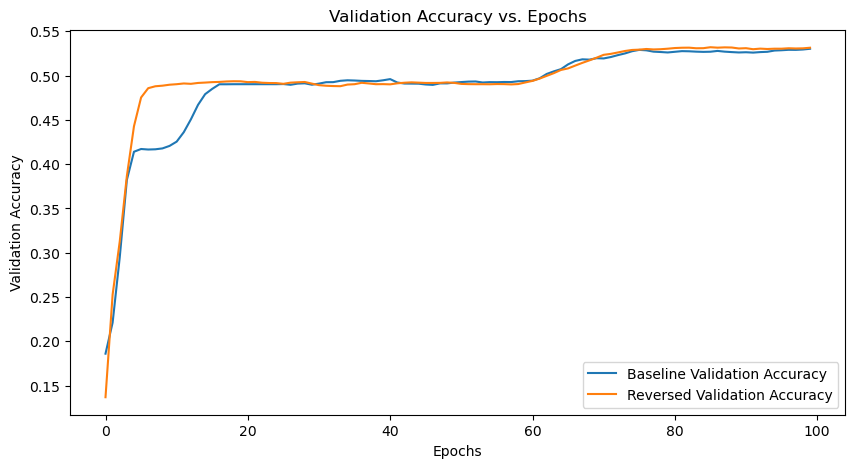

In [6]:
#f Plot
plt.figure(figsize=(10, 5))
plt.plot(val_acc, label='Baseline Validation Accuracy')
plt.plot(val_acc_rev, label='Reversed Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Epochs')
plt.legend()
plt.show()